In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install chronos-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


In [3]:
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline

In [4]:
# JSON 파일 경로
harris_file_path = '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/chronos/llm_sentiment_analysis_harris_time_series.json'
trump_file_path = '/content/drive/MyDrive/[인공지능기초]/predict/youtube/LLM/chronos/llm_sentiment_analysis_trump_time_series.json'

# JSON 파일 읽기 및 데이터프레임 변환 함수
def load_and_process_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    # JSON 데이터를 데이터프레임으로 변환
    df = pd.DataFrame(data.items(), columns=['date', 'score'])
    # 'date' 열을 datetime으로 변환
    df['date'] = pd.to_datetime(df['date'])
    # 인덱스를 'date'로 설정하고 정렬
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    return df

# Harris와 Trump 데이터 처리
harris_df = load_and_process_json(harris_file_path)
trump_df = load_and_process_json(trump_file_path)

In [5]:
# 예측 길이 설정 (3일 예측)
prediction_length = 3
quantile_levels = [0.5, 0.5, 0.5]  # 예측 구간 설정

In [6]:
# Chronos 모델 로드
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [7]:
# Harris 예측
harris_scores = harris_df['score'].values
quantiles_h, mean_h = pipeline.predict_quantiles(
    context=torch.tensor(harris_scores),
    prediction_length=prediction_length,
    quantile_levels=quantile_levels
)

forecast_index_h = pd.date_range(start=harris_df.index[-1] + pd.Timedelta(days=1), periods=prediction_length)
low_h, median_h, high_h = quantiles_h[0, :, 0].float().numpy(), quantiles_h[0, :, 1].float().numpy(), quantiles_h[0, :, 2].float().numpy()

prediction_df_harris = pd.DataFrame({'low':low_h, 'median':median_h, 'high':high_h}, index=forecast_index_h)

In [8]:
# Trump 예측
trump_scores = trump_df['score'].values
quantiles_t, mean_t = pipeline.predict_quantiles(
    context=torch.tensor(trump_scores),
    prediction_length=prediction_length,
    quantile_levels=quantile_levels
)

forecast_index_t = pd.date_range(start=trump_df.index[-1] + pd.Timedelta(days=1), periods=prediction_length)
low_t, median_t, high_t = quantiles_t[0, :, 0].float().numpy(), quantiles_t[0, :, 1].float().numpy(), quantiles_t[0, :, 2].float().numpy()

prediction_df_trump = pd.DataFrame({'low':low_t, 'median':median_t, 'high':high_t}, index=forecast_index_t)


In [9]:
prediction_df_harris

,low,median,high
2024-11-05,0.374422,0.374422,0.374422
2024-11-06,0.367635,0.367635,0.367635
2024-11-07,0.354061,0.354061,0.354061


In [10]:
prediction_df_trump

,low,median,high
2024-11-05,0.399119,0.399119,0.399119
2024-11-06,0.388979,0.388979,0.388979
2024-11-07,0.395432,0.395432,0.395432


In [11]:
# 과거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기거 데이터와 예측 데이터가 끊기지 않고 자연스럽게 잇기
harris_11_05 = pd.DataFrame({'score': [prediction_df_harris.loc['2024-11-05', 'median']]},
                             index=pd.to_datetime(['2024-11-05']))
trump_11_05 = pd.DataFrame({'score': [prediction_df_trump.loc['2024-11-05', 'median']]},
                            index=pd.to_datetime(['2024-11-05']))

harris_df_extended = pd.concat([harris_df, harris_11_05, prediction_df_harris], axis=0)
trump_df_extended = pd.concat([trump_df, trump_11_05, prediction_df_trump], axis=0)

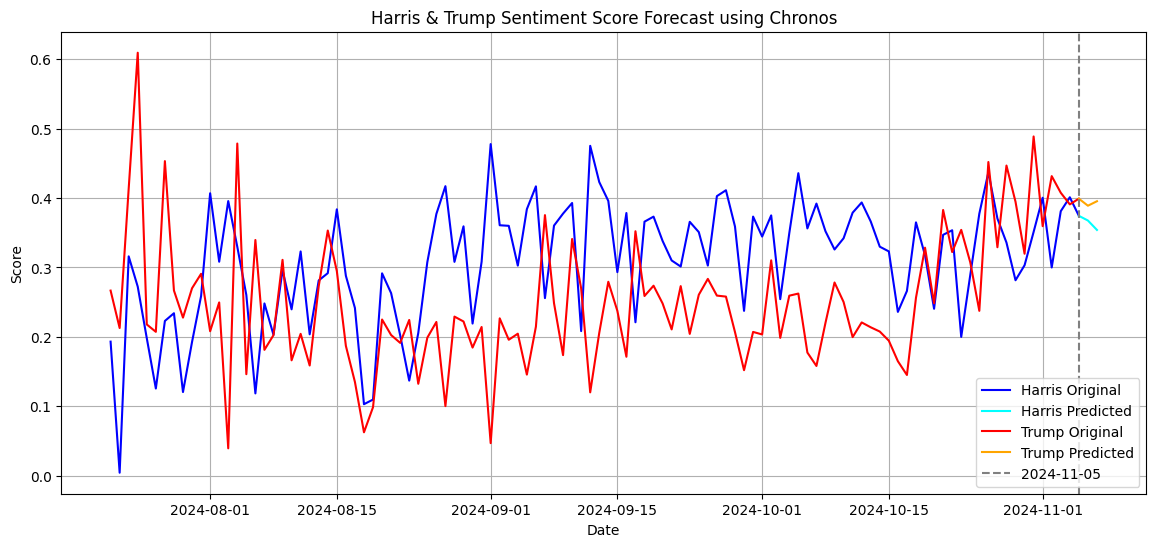

In [12]:
# Plot the extended data
plt.figure(figsize=(14, 6))

# Plot for Harris
plt.plot(harris_df_extended.index, harris_df_extended['score'], label='Harris Original', color='blue')
plt.plot(prediction_df_harris.index, prediction_df_harris['median'], label='Harris Predicted', color='cyan')

# Plot for Trump
plt.plot(trump_df_extended.index, trump_df_extended['score'], label='Trump Original', color='red')
plt.plot(prediction_df_trump.index, prediction_df_trump['median'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Sentiment Score Forecast using Chronos')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [13]:
# Filter the data for the specific date range (2024-11-02 to 2024-11-07)
date_range = pd.date_range(start='2024-11-02', end='2024-11-05')
pred_date_range = pd.date_range(start='2024-11-05', end='2024-11-07')

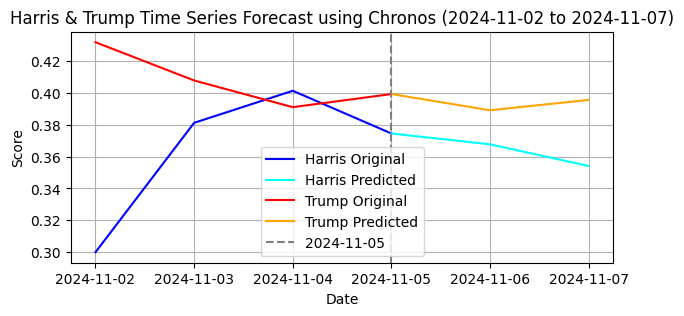

In [14]:
# Plot the extended data for the specified date range
plt.figure(figsize=(7, 3))

# Plot for Harris within the date range
harris_range = harris_df_extended.loc[date_range]
plt.plot(harris_range.index, harris_range['score'], label='Harris Original', color='blue')
harris_pred_range = prediction_df_harris.loc[pred_date_range]
plt.plot(harris_pred_range.index, harris_pred_range['median'], label='Harris Predicted', color='cyan')

# Plot for Trump within the date range
trump_range = trump_df_extended.loc[date_range]
plt.plot(trump_range.index, trump_range['score'], label='Trump Original', color='red')
trump_pred_range = prediction_df_trump.loc[pred_date_range]
plt.plot(trump_pred_range.index, trump_pred_range['median'], label='Trump Predicted', color='orange')

# Add vertical line at 2024-11-05
plt.axvline(pd.to_datetime('2024-11-05'), color='gray', linestyle='dashed', label='2024-11-05')

# Customize the plot
plt.title('Harris & Trump Time Series Forecast using Chronos (2024-11-02 to 2024-11-07)')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()